### Good Turing - QuadGram

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import re
import math
import pickle

In [3]:
df = pd.read_csv('Data/Unprocessed_Data/quadgram.csv')
df.head()

,Quadgram1,Quadgram2,Quadgram3,Quadgram4,Count,Prob
0,message,compose,to,r,1346,0.684639
1,if,you,have,any,1230,0.835598
2,you,have,any,questions,1217,0.931853
3,https,www,reddit,com,1186,0.982601
4,please,contact,the,moderators,1175,0.997453


In [3]:
## Making Dict of count : words
uni_good = {}
for i in range(len(df)):
    if df.iloc[i][4] in uni_good:
        uni_good[df.iloc[i][4]].append((df.iloc[i][0],df.iloc[i][1],df.iloc[i][2],df.iloc[i][3]))
    else:
        uni_good[df.iloc[i][4]] = [(df.iloc[i][0],df.iloc[i][1],df.iloc[i][2],df.iloc[i][3])]

In [5]:
import pickle
with open("quad_unigood_bkp.pkl", "wb") as pickle_file:
    pickle.dump(uni_good, pickle_file)

In [4]:
## Loading Data
import pickle
with open('Backup/quad_unigood_bkp.pkl','rb') as file:
    uni_good = pickle.load(file)

$$
\begin{align*}
\text{Good Turning Formula : }
c^* = \frac{(c+1)N_{c+1}}{N_c} 
\end{align*}
$$

In [23]:
## temp{} - c* : list of n-grams
temp = {}
for i in range(99,0,-1):
    ## i+1 == c+1
    ## len(uni_good[i+1]) = N_c+1
    ## len(uni_good[i]) = N_c
    ## c_star = c*
    c_star = (i+1)*len(uni_good[i+1])/len(uni_good[i])

    ##If count already present just add small value
    while c_star in temp:
        c_star = c_star+0.001
    temp[c_star] = uni_good[i]

##### Calculating Probabilities

In [24]:
new_count = np.sum(np.array(list(temp.keys())))

In [25]:
good_turining_count = {}

for i in temp:
    for j in temp[i]:
        good_turining_count[j] = i

## Adding rest of corpus
for i in uni_good:
    if i <= 200:
        break
    for j in uni_good[i]:
        good_turining_count[j] = i

In [26]:
## Importing Vocabulary
with open('Vocabulary.pkl','rb') as file:
    vocabulary = pickle.load(file)

In [27]:
## 0th Count
zero_count = len(uni_good[1])/((len(vocabulary)**4)-len(df))
print(zero_count)

2.3798701061084643e-14


In [28]:
### Getting sum of all the counts
sum = np.sum(np.array(list(good_turining_count.values()))) + zero_count
print(sum)

1114284.999999993


In [29]:
#### Converting good_turining_count dict from count to probability
for i in good_turining_count:
    good_turining_count[i] = good_turining_count[i]/sum

good_turining_count[0] = zero_count/sum

In [30]:
print("Sum of Prob = " + str(np.sum(np.array(list(good_turining_count.values())))))

Sum of Prob = 1.0000000000000115


In [31]:
good_turining_count[-1] = len(df)

In [32]:
with open("quadgram_prob.pkl", "wb") as pickle_file:
    pickle.dump(good_turining_count, pickle_file)

In [2]:
## Loading Data
import pickle
with open('quadgram_prob.pkl','rb') as file:
    good_turining_count = pickle.load(file)

### Testing

In [3]:
df = pd.read_csv('Data/testing_data.txt',
                 delimiter='\t',header=None, names=['Text'])
df.head()

,Text
0,"[START], woh, banda, kahan, hai, jo, kal, keh,..."
1,"[START], the, junta, will, end, up, with, a, b..."
2,"[START], that, doesn't, disprove, anything, i,..."
3,"[START], international, trade, relationships, ..."
4,"[START], hamare, pet, ki, bas, ki, bat, nhi, r..."


$$ log[PP(Perplexity)] = -\frac{1}{N} [log(P(w_2|w_1)) + ...  log(P(w_n|w_{n-1}))] $$

In [4]:
## Importing Unigram
with open('unigram_prob.pkl','rb') as file:
    unigram_probability = pickle.load(file)

## Importing Bigram
with open('bigram_prob.pkl','rb') as file:
    bigram_probability = pickle.load(file)

## Importing Trigram
with open('trigram_count.pkl','rb') as file:
    trigram_probability = pickle.load(file)

In [5]:
arr_pp = []
log_sum = 0
for j in range(len(df)):
    string1 = df.iloc[j][0].split(", ")
    ## Unigram probability / First word
    log_sum += math.log(unigram_probability[string1[0]])
    ## Bigram probability
    if (string1[0],string1[1]) in bigram_probability:
        log_sum += math.log(bigram_probability[(string1[0],string1[1])]) - math.log(unigram_probability[string1[0]])
    else:
        log_sum += math.log(bigram_probability[0]) - math.log(unigram_probability[string1[0]])
    ## Trigram probability
    if (string1[0],string1[1],string1[2]) in trigram_probability:
        log_sum += math.log(trigram_probability[(string1[0],string1[1],string1[2])]) - math.log(bigram_probability[(string1[0],string1[1])])
    else:
        ## Check if bigram present
        if (string1[0],string1[1]) in bigram_probability:
            log_sum += math.log(trigram_probability[0]) - math.log(bigram_probability[(string1[0],string1[1])])
        else:
            log_sum += math.log(trigram_probability[0]) - math.log(bigram_probability[0])

    ##
    for i in range(3,len(string1)):
        if (string1[i-3],string1[i-2],string1[i-1],string1[i]) in good_turining_count:
            log_sum += math.log(good_turining_count[(string1[i-3],string1[i-2],string1[i-1],string1[i])]) 
            - math.log(trigram_probability[(string1[i-3],string1[i-2],string1[i-1])])
        else:
            ## Check if trigram present
            if (string1[i-3],string1[i-2],string1[i-1]) in trigram_probability:
                log_sum += math.log(good_turining_count[0]) - math.log(trigram_probability[(string1[i-3],string1[i-2],string1[i-1])])
            else:
                log_sum += math.log(good_turining_count[0]) - math.log(trigram_probability[0])
    log_pp = -log_sum/len(string1)
    arr_pp.append(log_pp)

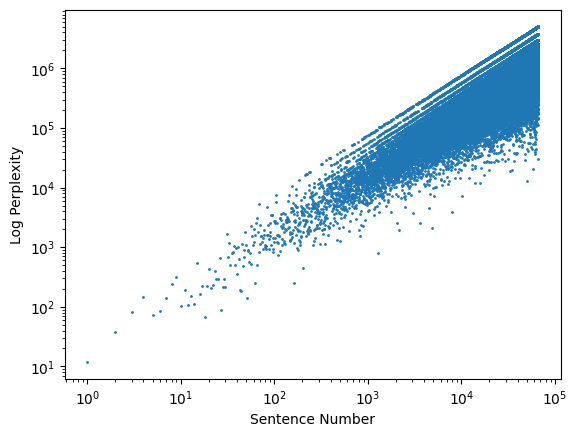

In [7]:
### PLoting the graph
x = list(range(1,len(df)+1))
plt.scatter(x,arr_pp,s=1)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Sentence Number')
plt.ylabel('Log Perplexity')
plt.show()

In [8]:
df = pd.read_csv('Data/Additive/quadgram_Perplexity_with_smoothing.csv')
df.head()

,Unnamed: 0,Data,Perplexity
0,0,"[START], woh, banda, kahan, hai, jo, kal, keh,...",55179.580133
1,1,"[START], the, junta, will, end, up, with, a, b...",20810.820268
2,2,"[START], that, doesn't, disprove, anything, i,...",7114.764122
3,3,"[START], international, trade, relationships, ...",10987.421286
4,4,"[START], hamare, pet, ki, bas, ki, bat, nhi, r...",25429.783375


In [9]:
y_additive = np.array(list(df['Perplexity'][:-1]))

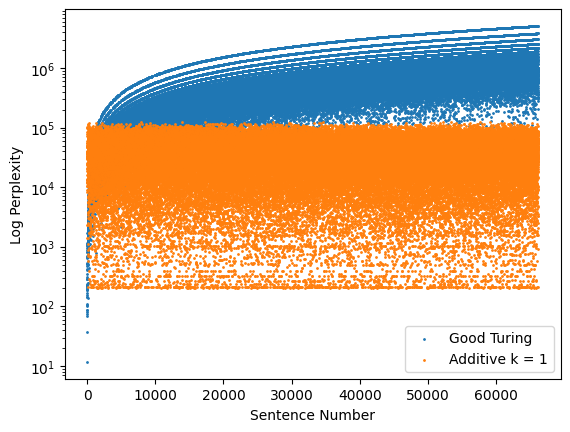

In [14]:
### PLoting the graph
x = list(range(1,len(df)))
plt.scatter(x,arr_pp,s=1,label='Good Turing')
plt.scatter(x,y_additive,s=1,label = 'Additive k = 1')
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Sentence Number')
plt.ylabel('Log Perplexity')
plt.legend()
plt.show()

As per the above image we can see that Additive-1 smoothing is performingmuch better than Good turing.

But there are little data points Good Turing is performing better than Additive Smoothing.

In this case Additive smoothing is much prefered.

In [11]:
df = pd.read_csv('Data/Additive/quadgram_Perplexity_with_smoothing_additive.csv')
df.head()

,Unnamed: 0,Data,Perplexity
0,0,"[START], woh, banda, kahan, hai, jo, kal, keh,...",83685.515117
1,1,"[START], the, junta, will, end, up, with, a, b...",35690.833666
2,2,"[START], that, doesn't, disprove, anything, i,...",12002.741188
3,3,"[START], international, trade, relationships, ...",15750.645295
4,4,"[START], hamare, pet, ki, bas, ki, bat, nhi, r...",48135.505810


In [12]:
y_additive = np.array(list(df['Perplexity'][:-1]))

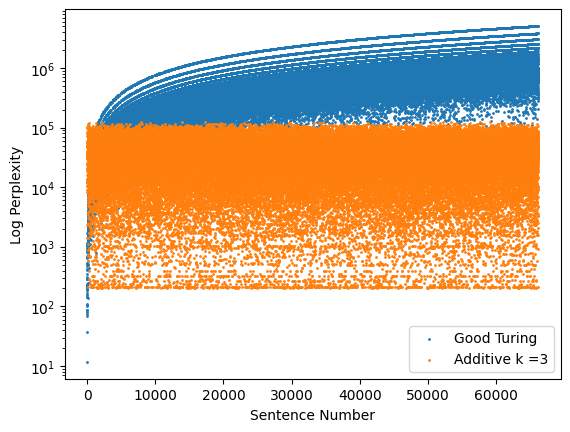

In [15]:
### PLoting the graph
x = list(range(1,len(df)))
plt.scatter(x,arr_pp,s=1,label='Good Turing')
plt.scatter(x,y_additive,s=1,label = 'Additive k =3')
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Sentence Number')
plt.ylabel('Log Perplexity')
plt.legend()
plt.show()